# Feature Visualization: Interpretation of How Neural Network Understands Images
**Name:** Maharsh Raval <br>
**Roll No**: 210108026

# Motivation

What if we could peek inside a neural network and actually see what it’s paying attention to when it looks at an image?

That’s what feature visualization helps us do. In simple terms, it’s a way to understand how deep learning models—especially Convolutional Neural Networks (CNNs)—recognize patterns in images.

Today’s AI systems are very good at tasks like detecting faces, identifying objects, or even diagnosing diseases from medical scans. But even though these models work well, we often don’t understand how they make their decisions. They behave like **black boxes**: we give them an image, they give us a prediction—but the process in between is hard to explain.

![NN_as_BB](https://media.licdn.com/dms/image/v2/D5612AQFdFw2HHGQWNQ/article-cover_image-shrink_720_1280/article-cover_image-shrink_720_1280/0/1710392054097?e=1752105600&v=beta&t=fyvFeD2lHNrqQhW8j3SACOyYyKTrLMCFggO-1SKCj_8 "Neural Network as a Black Box")

That’s a problem when we want AI to be more trustworthy, transparent, and fair. Especially in fields like healthcare, law, or education, it’s important to know why a model made a certain choice.

One way to explore this is by visualizing what each layer or filter in a neural network is looking for. For example, some filters might detect edges or colors, while deeper ones might recognize textures or shapes. We can even generate artificial images that "excite" a filter, helping us understand the kinds of features it responds to.

In this project, we’ll walk through how to create these visualizations using a CNN model called VGG-16.

By the end, we’ll not only see some cool patterns, but also gain a better understanding of how neural networks learn to "see" the world.


# How does it connect with past and current work done in the Vision Domain?
In the vision domain, understanding what features neural networks extract from images is foundational. This work is rooted in earlier CNN interpretability research:

- Zeiler & Fergus (2013) introduced deconvolutional visualizations.
- Yosinski et al. (2015) explored activation maximization.

Recently, self-supervised models like DINO and MAE show that even without labels, CNNs can learn meaningful image representations, often producing sharper and more focused attention maps.

This contributes to the interpretability of CNN-based classifiers, offering insights into their feature hierarchy and helping bridge the gap between prediction and understanding.

# My Key Learnings

- Feature maps in deep layers correspond to high-level patterns (e.g., windows, rooftops).

- Not all filters activate equally -- only a few respond strongly to any given image.

- We can visualize which filters respond most and what excites them most, improving transparency.

# Code
Lets understand the code and observe some cool patterns which Neural Network uses to understand images

## Importing Essential Libraries

In [ ]:
# Importing all libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from torchvision.models import vgg16

## Filter Visualizer

Now, we'll be visualizing what patterns a CNN filter responds to by:

- Starting from a random image,
- Keeping the VGG16 weights frozen,
- Updating only the input pixel values to maximize activation of a chosen filter,
- Using gradient ascent on pixel values.

This process is inspired by **Neural Style Transfer** and helps us understand what each filter has learned to detect.

### 1. SaveFeatures -- Activation Hook
First let us understand what is Hook?
A hook is a function that can be attached to any **Pytorch** Module (i.e., any layer like **Conv2d**, **ReLU**, etc.). When the model runs and that specific layer is reached during a forward pass, the hook is triggered automatically.

Hooks allow us to "peek" at the layer’s inputs, outputs, or gradients — without interrupting the normal flow of the model.

This class performs various tasks:
- Hooks into a specific layer in the VGG16 network.
- Saves the output feature maps (activations) when the model is run.
- close() removes the hook to prevent memory leaks.

In [2]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

### 2. FilterVisualizer -- The Main Hero of Our Story
The class **FilterVisualizer** lets us pick any filter from any convolutional layer in a pretrained **VGG16** model, and then generate an input image that excites that filter the most.

a. preprocess(): Resize and convert to a torch tensor
This method:
- Resizes the image to a target size (sz × sz)
- Normalizes and formats it to PyTorch's channel-first format: (1, 3, H, W)
- Sets requires_grad_(True) so that we can optimize the pixels using gradient descent.

b. postprocess(): Convert tensor back to displayable image
This method reverses preprocessing so we can:
- View the image using OpenCV or matplotlib
- Clamp pixel values between 0 and 1

c. get_mean_activation(): Plot mean activation per filter for a specific layer
Here:
- Pass an image through the model
- Register a forward hook on a layer using SaveFeatures (previously defined)
- Grab the average activation of each filter in that layer

d. visualize(): Generate an Image That Excites a Filter
Here:
- Start with a random image `(np.random.rand(sz, sz, 3) * 0.3 + 0.5).astype(np.float32)`
- To improve the quality and resolution of the visualization:
    - Start with a small image (e.g., 56x56)
    - Optimize it for a few steps
    - Upscale it by a factor (e.g., 1.2x)
    - Repeat this process **upscaling_steps** times
- In the inner loop
    - Passes the image through the model
    - Computes the mean activation of a specific filter
    - Backpropagates the negative of that activation (because I am doing gradient ascent to maximize it)
    - Updates the image pixels using Adam optimizer

In [3]:
class FilterVisualizer():
    def __init__(self):
        self.model = vgg16(weights='IMAGENET1K_V1').features.cuda().eval()
    
    def preprocess(self, img, sz):
        img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)
        img = np.clip(img, 0, 1)
        img = torch.tensor(img).permute(2,0,1).unsqueeze(0).float().cuda()
        img.requires_grad_(True)
        return img

    def postprocess(self, img_tensor):
        img = img_tensor.squeeze().detach().cpu().permute(1,2,0).numpy()
        img = np.clip(img, 0, 1)
        return img

    def get_mean_activations(self, layer_idx, input_img):
        img_var = self.preprocess(input_img.copy(), 56)
        layer = list(self.model.children())[layer_idx]
        activations = SaveFeatures(layer)
        self.model(img_var)
        num_filters = activations.features.shape[1]
        mean_activations = [activations.features[0, i].mean().item() for i in range(num_filters)]
        activations.close()
        return mean_activations

    def visualize(self, sz, layer_idx, filter_idx, upscaling_steps=12, upscaling_factor=1.2, 
                  lr=0.1, opt_steps=20, blur=None, print_losses=False):
        img = (np.random.rand(sz, sz, 3) * 0.3 + 0.5).astype(np.float32)
        layer = list(self.model.children())[layer_idx]
        activations = SaveFeatures(layer)
        
        for i in range(upscaling_steps):
            img_var = self.preprocess(img, sz)
            optimizer = optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            opt_steps_ = int(opt_steps * 1.3) if i > upscaling_steps/2 else opt_steps
            for n in range(opt_steps_):
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter_idx].mean()
                loss.backward()
                optimizer.step()
            img = self.postprocess(img_var)
            sz = int(sz * upscaling_factor)
            img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)
            if blur: img = cv2.blur(img, (blur, blur))
        
        activations.close()
        return np.clip(img, 0, 1)

FV = FilterVisualizer()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.1MB/s] 


### Observe the Increase in Complexity of Layers with Depth

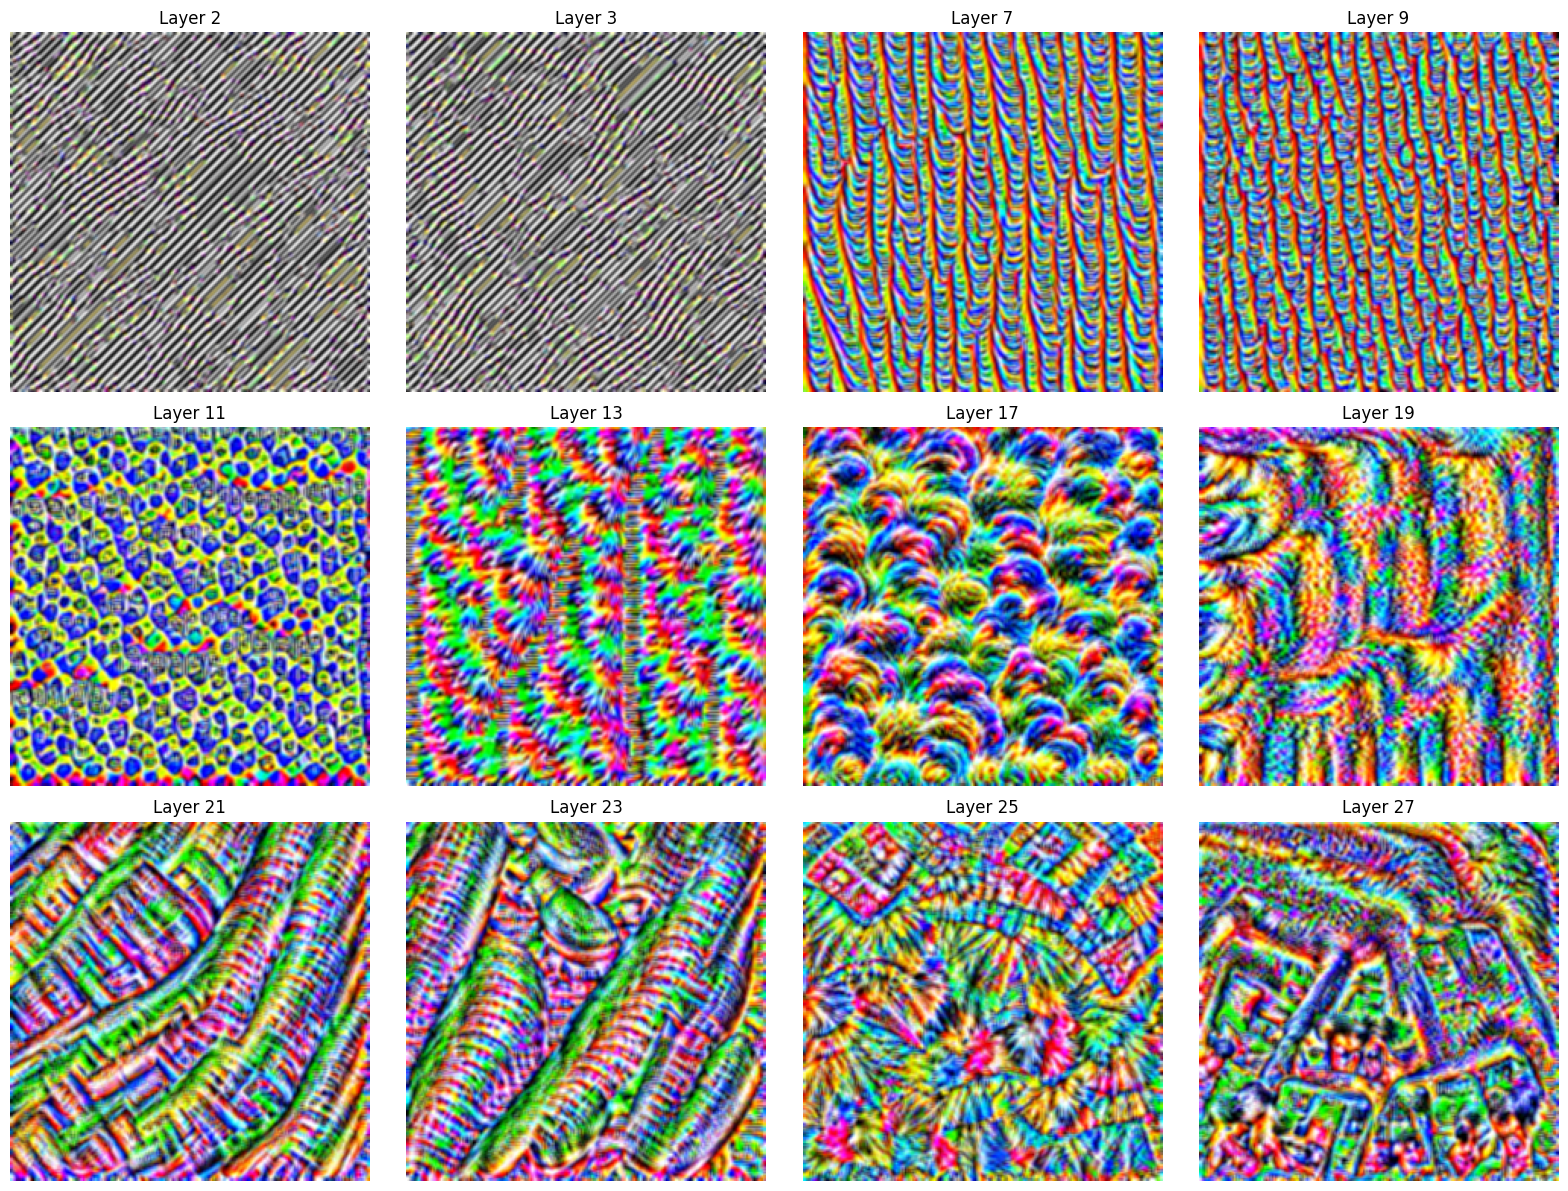

In [4]:
layer_indices = [2, 3, 7, 9, 11, 13, 17, 19, 21, 23, 25, 27]
filter_idx = 5
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, layer_idx in enumerate(layer_indices):
    out_img = FV.visualize(
        sz=56,
        layer_idx=layer_idx,
        filter_idx=filter_idx,
        upscaling_steps=8,
        opt_steps=15,
        blur=3,
        print_losses=False 
    )
    axes[i].imshow(out_img)
    axes[i].axis('off')
    axes[i].set_title(f"Layer {layer_idx}")

for j in range(len(layer_indices), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Next in this section, we're taking a step-by-step deep dive into the brain of a **Convolutional Neural Network** — specifically, a **VGG16** model — to see how it interprets a given input image.

The idea is to:
- Feed an image into the network.
- Measure how strongly each filter responds (i.e., its activation or simply which filters finds the image interesting !!) in a selected layer.
- Identify the top-k filters that respond the most.
- Generate images that maximally activate those top filters using the FilterVisualizer.

This allows us to both quantify the neural response and visualize what each filter is “looking for” — giving insight into what abstract features the CNN has learned.

/tmp/ipykernel_31/3864224796.py:44: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


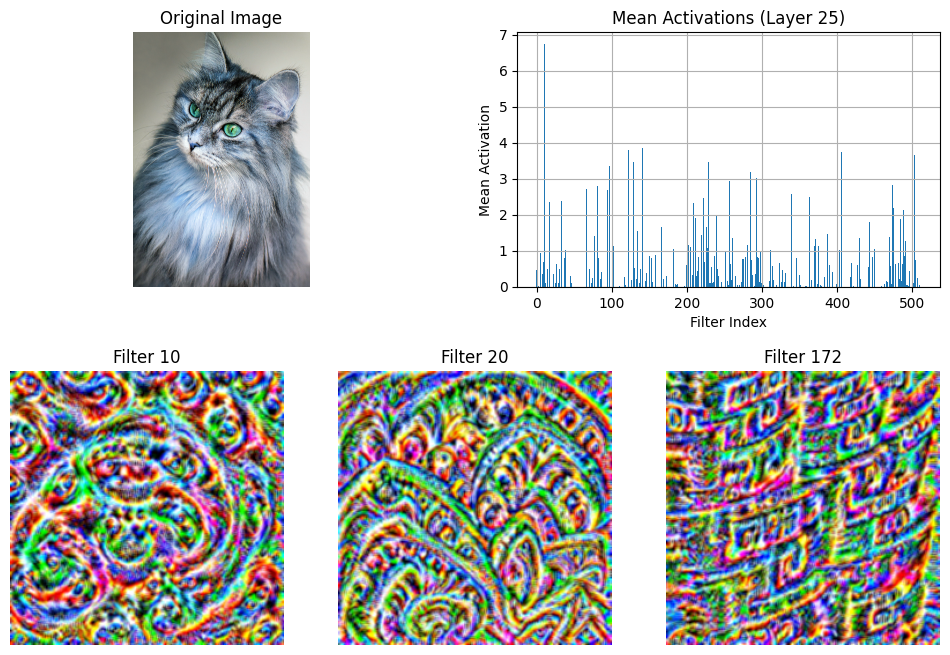

In [5]:
def visualize_features(image_path, layer_idx, top_k):
    selected_layer = layer_idx
    top_k = top_k
    base_img = cv2.imread(image_path)
    
    
    mean_activations = FV.get_mean_activations(selected_layer, base_img)
    sorted_indices = np.argsort(mean_activations)[::-1]
    top_k_indices = sorted_indices[:top_k]
    
    
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])
    
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(base_img)
    ax1.axis('off')
    ax1.set_title("Original Image")
    
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(np.arange(len(mean_activations)), mean_activations)
    ax2.set_title(f"Mean Activations (Layer {selected_layer})")
    ax2.set_xlabel("Filter Index")
    ax2.set_ylabel("Mean Activation")
    ax2.grid(True)
    
    for i, filter_idx in enumerate(top_k_indices):
        ax = fig.add_subplot(2, 3, i + 4) 
        out_img = FV.visualize(
            sz=56,
            layer_idx=selected_layer,
            filter_idx=filter_idx,
            upscaling_steps=8,
            opt_steps=20,
            blur=3,
            print_losses=False
        )
        ax.imshow(out_img)
        ax.axis('off')
        ax.set_title(f"Filter {filter_idx}")
    
    plt.tight_layout()
    plt.show()

visualize_features("/kaggle/input/cat-image/cat.jpg",25,3)

### Conclusion:
Above output provides a fascinating look inside the inner workings of a Convolutional Neural Network (CNN), specifically VGG16, as it analyzes a photo of a cat.

- The bar graph in top-right corner shows that not all filters are equally active. A select few filters (here, 10, 20, and 172) are highly stimulated, suggesting they are particularly tuned to detect features prominent in the cat image — such as fur textures, edge orientations, or eye contours.

- The visualizations for each top filter reveal the abstract patterns each filter is sensitive to. For example:
    - Filter 10 might specialize in concentric circular textures.
    - Filter 20 reacts to repeating arch-like waveforms.
    - Filter 172 seems tuned to dense diagonal or grid-like structures.

These filters aren’t detecting cats directly — instead, they’re picking up mid-level patterns that collectively help the network understand and classify high-level concepts like “cat.”

- Since this was done at layer 25, which lies deep in the VGG16 architecture, the filters are likely detecting compositional and textured patterns rather than simple edges or colors. This confirms that deeper layers extract more abstract and semantically rich features, critical for accurate image understanding.

This kind of visualization helps illustrate what a CNN is “looking for.” Rather than operating as a black box, we gain transparency into how the network processes information, which is essential for interpretability, debugging, and trust in AI systems.

### Some More Visualization
1. For Outer Layers (say, layer 6):

/tmp/ipykernel_31/3864224796.py:44: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


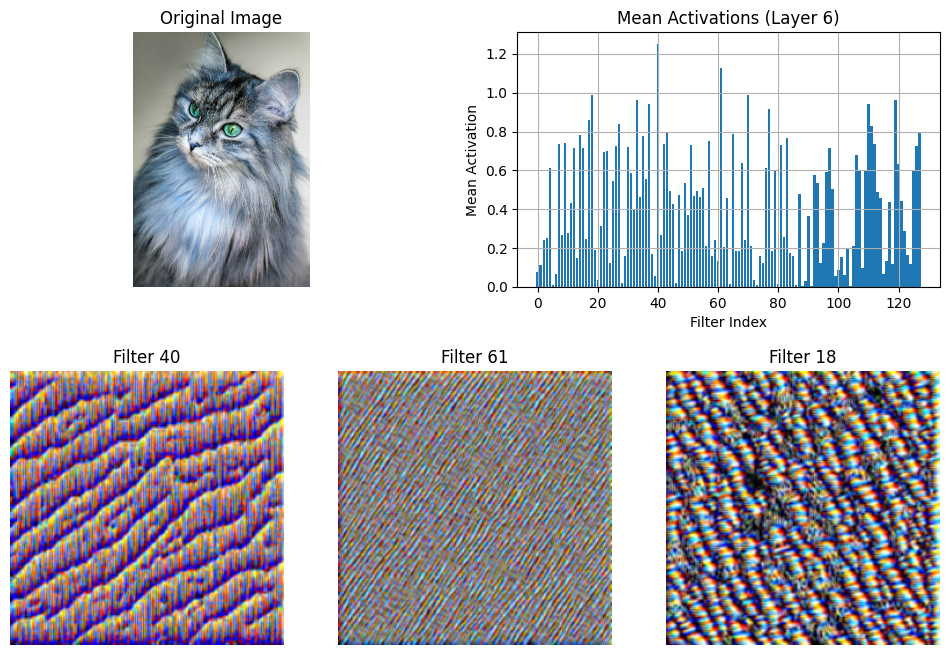

In [6]:
visualize_features("/kaggle/input/cat-image/cat.jpg",6,3)

2. For Middle Layers (say, layer 15):

/tmp/ipykernel_31/3864224796.py:44: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


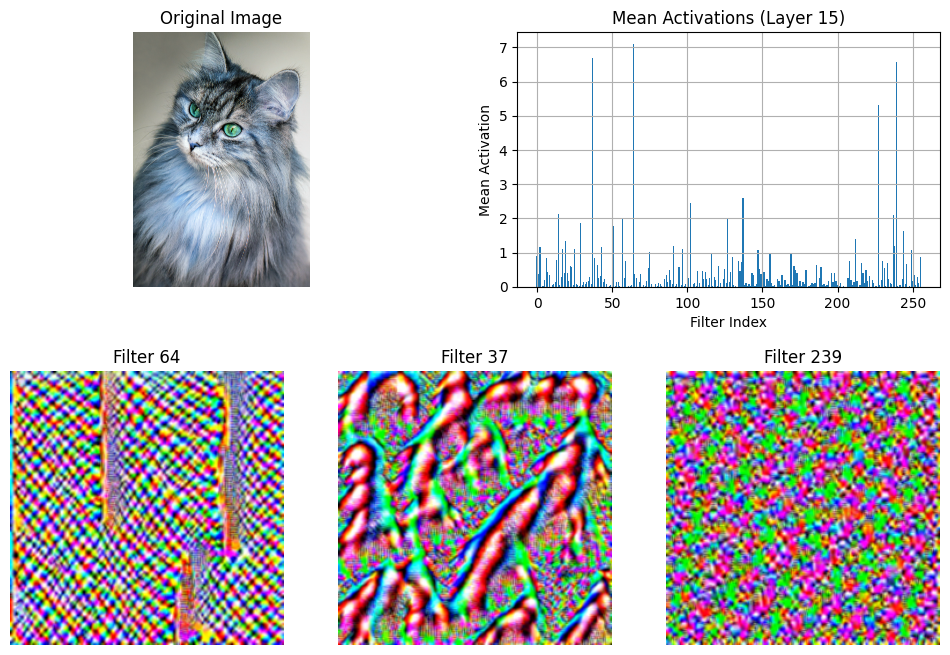

In [7]:
visualize_features("/kaggle/input/cat-image/cat.jpg",15,3)

# References
- C. Olah, A. Mordvintsev, and L. Schubert, “Feature Visualization,” Distill, 2017. [Online]. Available: https://distill.pub/2017/feature-visualization/